## IMPORT DATASET DAN LIBRARY

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
# Load dataset
df = pd.read_csv('IMDB Dataset.csv')

In [5]:
# lihat beberapa baris dataset
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


## EKSPLORASI DATA

## Periksa Struktur Data

In [8]:
# periksa info dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [9]:
# periksa sentiment
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Visualisasi distribusi sentimen

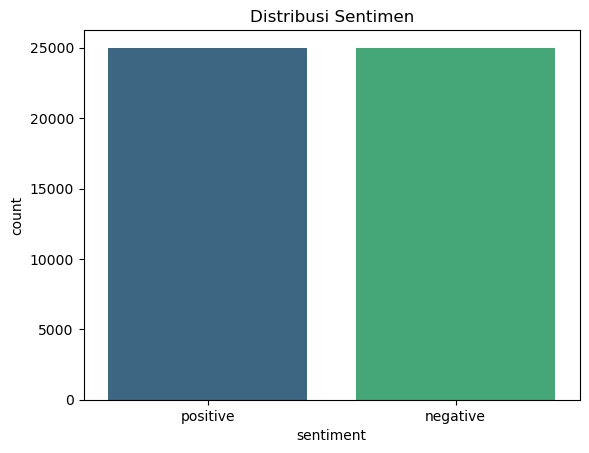

In [11]:
sns.countplot(data=df, x='sentiment', hue='sentiment', palette='viridis', legend=False)
plt.title('Distribusi Sentimen')
plt.show()

## PREPROCESSING DAN DATA CLEANING

### Konversi teks ke huruf kecil

In [14]:
df['review'] = df['review'].str.lower()

### Hapus tanda baca, angka, dan karakter khusus

In [16]:
df['review'] = df['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))

### Tokenisasi teks : Memecah teks menjadi kata-kata individu

In [18]:
df['review'] = df['review'].apply(word_tokenize)

## Hilangkan kata-kata tidak bermakna (stopwords)

In [20]:
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: [word for word in x if word not in stop_words])

In [21]:
# Menghapus kata 'br' dari setiap tokenized review
df['review'] = df['review'].apply(lambda review: [word for word in review if word != 'br'])

### Lemmatization: Mengubah kata ke bentuk dasar

In [23]:
# Fungsi untuk mendapatkan POS tag untuk WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

lemmatizer = WordNetLemmatizer()

# Fungsi untuk lemmatize setiap review
df['review'] = df['review'].apply(lambda x: [
    lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tag(x)
])

### Visualisasi kata-kata yang sering muncul menggunakan WordCloud

In [25]:
df['review'] = df['review'].astype(str)

positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['review'])
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['review'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)

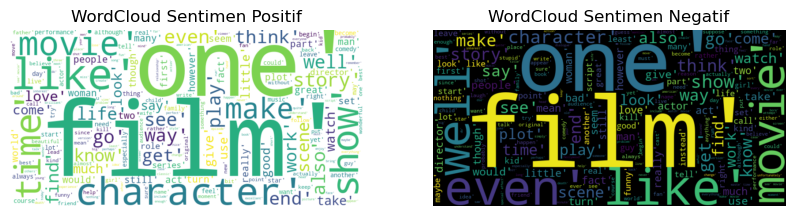

In [26]:
# Tampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('WordCloud Sentimen Positif')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('WordCloud Sentimen Negatif')
plt.axis('off')
plt.show()

## TEXT REPRESENTATTION

In [28]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['review']).toarray()
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)  # Ubah label ke numerik

## TRAINING MODEL NLP

### Split data Menjadi Training, Val, Dan Test

In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### Logistic Regression

In [33]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## EVALUASI MODEL

In [35]:
# Evaluasi pada data validasi
print("Evaluasi pada Data Validasi:")
y_val_pred = model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Evaluasi pada Data Validasi:
Validation Accuracy: 0.8884
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2500
           1       0.87      0.91      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [36]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8848
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2500
           1       0.88      0.89      0.89      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



### Tampilkan Convusion Matrix

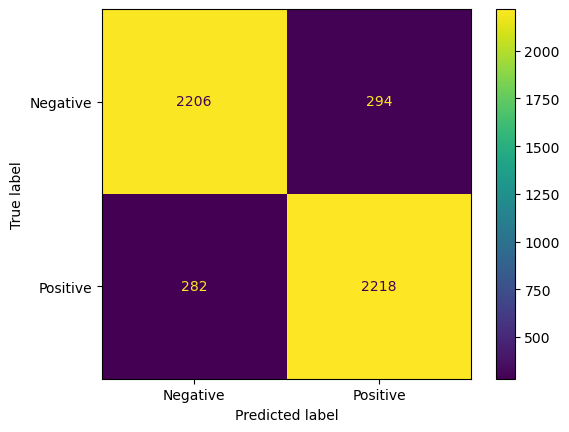

In [38]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='viridis')
plt.show()

## SIMPAN MODEL 

In [40]:
import pickle

# Simpan TfidfVectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

# Simpan model
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Vectorizer dan model berhasil disimpan.")

Vectorizer dan model berhasil disimpan.


## PREDIKSI REVIEW BARU

In [42]:
# Muat TfidfVectorizer
with open('vectorizer.pkl', 'rb') as file:
    tfidf = pickle.load(file)

# Muat model
with open('sentiment_model.pkl', 'rb') as file:
    model = pickle.load(file)

print("Vectorizer dan model berhasil dimuat.")

Vectorizer dan model berhasil dimuat.


In [43]:
new_reviews = ["This movie was a masterpiece!", "I found the film extremely boring."]
new_reviews_cleaned = [
    ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(re.sub(r'[^a-zA-Z\s]', '', review.lower())) if word not in stop_words])
    for review in new_reviews
]

new_reviews_tfidf = tfidf.transform(new_reviews_cleaned)
predictions = model.predict(new_reviews_tfidf)
print(predictions)  # 1 untuk positif, 0 untuk negatif

[1 0]


In [44]:
# Fungsi untuk preprocessing teks
def preprocess_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Hilangkan karakter non-huruf
    tokens = word_tokenize(cleaned_text)  # Tokenisasi
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [45]:
# Teks baru untuk prediksi
new_reviews = ["The movie was so good!", "The movie was bad"]

In [46]:
# Preprocessing teks
new_reviews_cleaned = [preprocess_text(review) for review in new_reviews]

In [47]:
# Transformasi teks ke fitur numerik menggunakan TfidfVectorizer
new_reviews_tfidf = tfidf.transform(new_reviews_cleaned)

In [48]:
# Lakukan prediksi menggunakan model
predictions = model.predict(new_reviews_tfidf)

In [49]:
# Tampilkan hasil prediksi
for review, prediction in zip(new_reviews, predictions):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Review: {review}\nSentiment: {sentiment}\n")

Review: The movie was so good!
Sentiment: Positive

Review: The movie was bad
Sentiment: Negative

